In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [20]:
df = pd.read_csv('Medical Insurance Train Data.csv')
df


,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900
...,...,...,...,...,...,...,...
3625,48.820767,female,41.426984,no,northwest,4,10987.324964
3626,38.661977,female,26.202557,no,southeast,2,11735.844352
3627,56.000000,male,40.300000,no,southwest,0,10602.385000
3628,48.061207,female,34.930624,no,southeast,1,8976.140452


In [62]:
text = ['sex', 'smoker', 'region']
num = ['age', 'bmi', 'children']

trf = ColumnTransformer([
    ('trf1', StandardScaler(), num)
], remainder='passthrough')

oe = OrdinalEncoder(categories=[
    ['male', 'female'],      # order for sex
    ['no', 'yes'],           # order for smoker
    ['northeast', 'southeast', 'northwest', 'southwest']   # order for region
])


"""
MANUALLY DOING ORDINAL ENCODING

df['sex'] = df['sex'].map({'female':0, 'male':1})
df['smoker'] = df['smoker'].map({'no':0, 'yes':1})
df['region'] = df['region'].map({'southwest':0, 'southeast':1, 'northwest':2, 'northeast':3})

"""


x = df.iloc[:, :6]
y = df.iloc[:, 6:7]


x[text] = oe.fit_transform(x[text])
x[num] = trf.fit_transform(x[num])

x = pd.DataFrame(pd.concat([x[text], x[num], y], axis=1))

# more the corr is close to 1 will be highly corelated and imp, and vice-versa for being closer to 0
print(x.head(), "\n\n")
print("CORR WITH ALL THE COLUMNS : \n", x.corr(), "\n\n")         # this will show correlation of one column with each column

print("CORR ONLY WITH 'charges' : ")
corr_target = x.corr()['charges'].drop('charges')       # this will show correlation of all the columns only with output column ['charges']
corr_target     # as we can see in the column, [sex, region, and children] are very less corelated, hence we can remove them and do the dimensionality reduction



   sex  smoker  region       age       bmi  children       charges
0  0.0     0.0     0.0 -1.472262 -0.897822 -0.294091   3279.868550
1  1.0     1.0     1.0 -0.157215 -0.897976  0.289908  21454.494239
2  0.0     0.0     1.0 -1.719189 -0.110219 -0.878090   1720.353700
3  0.0     0.0     0.0 -0.155320  0.008683  0.289908   6801.437542
4  0.0     0.0     1.0  1.573167  0.253714 -0.878090  11946.625900 


CORR WITH ALL THE COLUMNS : 
                sex    smoker    region       age       bmi  children   charges
sex       1.000000 -0.078318  0.053221  0.152745  0.011215 -0.147182 -0.092703
smoker   -0.078318  1.000000 -0.091752  0.026564  0.045921 -0.183507  0.777175
region    0.053221 -0.091752  1.000000 -0.052556 -0.019890  0.069923 -0.155723
age       0.152745  0.026564 -0.052556  1.000000  0.143527 -0.061076  0.299692
bmi       0.011215  0.045921 -0.019890  0.143527  1.000000 -0.041996  0.211325
children -0.147182 -0.183507  0.069923 -0.061076 -0.041996  1.000000 -0.075089
charges  -0.

sex        -0.092703
smoker      0.777175
region     -0.155723
age         0.299692
bmi         0.211325
children   -0.075089
Name: charges, dtype: float64

In [70]:
np.round(corr_target, 2)*100
#  now you can easily see the columns with very low corr with 'charges'


sex         -9.0
smoker      78.0
region     -16.0
age         30.0
bmi         21.0
children    -8.0
Name: charges, dtype: float64

In [ ]:

"""
    Positive correlation (+ve integers) means the feature increases when charges increase.
    Negative correlation (-ve integers) means the feature decreases when charges increase.
    The sign (+ or -) only shows direction, not importance.
    Importance is based on the absolute value of the correlation.

    smoker has +78 → strong positive relationship → keep
    age has +30 → moderate positive → keep
    bmi has +21 → weak positive → optional but usually keep
    region has -16 → weak negative → can drop
    sex has -9 → very weak negative → drop
    children has -8 → very weak negative → drop

    General rule:
    |corr| < 0.10 → no meaningful relationship → drop
    |corr| 0.10-0.30 → weak → optional
    |corr| > 0.30 → meaningful → keep


INTERPRETATION --

Feature      Corr %   Interpretation
---------------------------------------------------------------------------
smoker       +78      Smokers have much higher charges.
age          +30      Older individuals pay more on average.
bmi          +21      Higher BMI tends to increase charges.
region       -16      Region slightly decreases or shifts charges (this means different pay based on different regions).
sex          -9       Sex has almost no meaningful effect.
children     -8       Number of children has minimal impact.



THINGS TO KEEP IN MIND WHILE USING CORR :

1. Correlation does NOT imply causation. It only shows association, not the reason behind it.
2. Correlation measures only **linear** relationships. If the relationship is non-linear, correlation can be misleading or show near zero.
3. Correlation is **sensitive to outliers**. A few extreme values can drastically change the correlation value.
4. Correlation requires **numeric data**. If categorical variables are encoded poorly (e.g., ordinal encoding when order doesn't make sense), correlation results can become misleading.
5. Correlation evaluates **each feature independently**, not feature interactions. Some features may matter only when combined with others.
6. **Multicollinearity** matters. If two features are highly correlated with each other, their individual correlation with the target may be confusing to interpret.
7. Scaling does not affect correlation, but **incorrect encoding choices** can change interpretation.

Good practice:
Use correlation as an initial filter, but always confirm using model-based feature importance or SHAP to understand true influence.



WHAT TO DO, WHEN THE DATA IS IN CATEGORICAL TEXT ?? AS ORDINAL ENCODING FOR THESE DATA CAN BE MISLEADING

    Correct approach:
    1. Numeric   vs   Numeric → Pearson correlation
    2. Categorical (input)  vs  Categorical (output) → Cramer's V (or Chi-Square association)
    3. Categorical (input)  vs  Numeric (output) → Point-Biserial correlation (or ANOVA)


________________________________________________________________________________________________________________________________________________________________________________________________________________


WHAT TO DO WHEN THE INPUT IN TEXT OR CATEGORICAL AND OUTPUT IN TEXT 
WHAT TO DO WHEN THE INPUT IN TEXT OR CATEGORICAL AND OUTPUT IN CATEGORICAL

CASE SELECTION FOR CORRELATION / FEATURE-ASSOCIATION ANALYSIS

1) When OUTPUT is NUMERIC → Regression-type correlation

   a) Numeric input → Numeric output:
      Use PEARSON correlation.

   b) Binary categorical input → Numeric output:
      Use POINT-BISERIAL correlation.

   c) Categorical input with more than 2 categories → Numeric output:
      Use ANOVA or Kruskal-Wallis instead of correlation.


2) When OUTPUT is CATEGORICAL → Classification-type association

   a) Numeric input → Categorical output:
      Use Logistic Regression feature coefficients or MUTUAL INFORMATION.

   b) Categorical input → Categorical output:
      Use CRAMER'S V.

   c) Mixed numeric + categorical → Categorical output:
      Use MUTUAL INFORMATION (most general and safest).


SUMMARY TABLE
--------------------------------------------------
Input vs Output                    | Best Method
--------------------------------------------------
Numeric → Numeric                  | Pearson Correlation
Binary Categorical → Numeric       | Point-Biserial Correlation
Multi-Categorical → Numeric        | ANOVA / Kruskal-Wallis
Numeric → Categorical              | Logistic Coeff / Mutual Information
Categorical → Categorical          | Cramer's V
Mixed → Categorical                | Mutual Information


KEY RULE:
Do NOT use Pearson correlation on Ordinal-Encoded categorical variables 
if the ordering is artificial. The sign and magnitude will be misleading.


"""

sex         -9.0
smoker      78.0
region     -16.0
age         30.0
bmi         21.0
children    -8.0
Name: charges, dtype: float64

## Other Ways we can use, to find corr without using corr

In [ ]:
# using random forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x, y)
pd.Series(rf.feature_importances_, index=x.columns)

C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


sex         3.776948e-06
smoker      4.245633e-07
region      1.638790e-05
age         1.829161e-05
bmi         1.834580e-05
children    1.167146e-05
charges     9.999311e-01
dtype: float64

In [ ]:
# using Permutation Importance
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, x, y, n_repeats=5)
pd.Series(result.importances_mean, index=x.columns)

sex         5.908968e-07
smoker      6.314957e-08
region      4.004384e-06
age         5.966938e-06
bmi         4.409594e-06
children    1.103356e-05
charges     2.023537e+00
dtype: float64

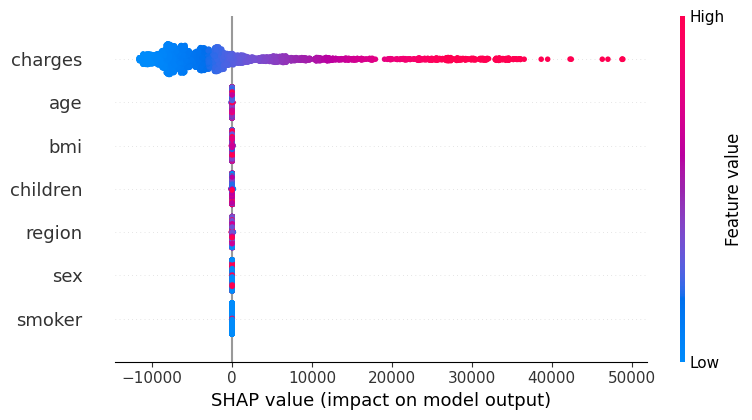

In [ ]:
# using SHAP Values
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)


In [ ]:
# using Mutual Information (MI)
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(x, y)
pd.Series(mi, index=x.columns)


C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sex         0.191223
smoker      0.317672
region      0.341106
age         1.851768
bmi         0.541868
children    0.623328
charges     6.900971
dtype: float64

In [ ]:
# ANOVA F-score (for continuous target)
from sklearn.feature_selection import f_regression
f_scores, p_values = f_regression(x, y)
pd.Series(f_scores, index=x.columns)



C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sex         3.144864e+01
smoker      5.533651e+03
region      9.016445e+01
age         3.580036e+02
bmi         1.695944e+02
children    2.057190e+01
charges    -8.169530e+18
dtype: float64